In [ ]:
%matplotlib inline

from pathlib import Path
import random
import decimal

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


# The Winner's Curse

The Winner's Curse is a situation where a experiment is highly underpowered to reliably detect the real effect, so the resulting ATE is certain to be highly overestimated.

In this notebook we will perform 1000 A/B simulations with different sample sizes (resulting in experiments with different power to detect
 the same real effect) and compare the average ATE from these simulations with the real ATE (5%).

In [ ]:
# calculate sample sizes for different powers
effect_size = statsmodels.stats.proportion.proportion_effectsize(0.21, 0.20)  # Calculate effect size for variant population with convertion rate of 21% and control population with convertion rate of 20%
alpha = 0.05
ratio = 1.0
power_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.70,0.8,0.9] # list of power levels to calculate sample sizes
sample_sizes = []

for power in (power_list):
  result = NormalIndPower().solve_power(effect_size=effect_size, alpha=alpha, nobs1=None, power=power, ratio=ratio, alternative='larger')
  sample_sizes.append(round(result,0))

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# tests parameters
n_tests = 1000 # number of A/B tests to simulate
n_obs_list = sample_sizes # list with different sample sizes for each variant in the tests
conv_control = 0.2
conv_variant = 0.21
alpha = 0.05

# Create DataFrame
df = pd.DataFrame(columns=('n', 'power', 'effect', 'p-value','exageration_ratio'))

# for each sample size, simulate 1000 A/B tests and record the results
for n_obs in (n_obs_list):
  for k in range(n_tests):

    # sample 1 time from the control binomial distribution
    n, p = n_obs, conv_control
    tests = 1
    samples = np.random.binomial(n, p, tests)
    success_A = samples[0]
    trials_A = n

    # sample 1 time from the treatment variant binomial distribution
    n, p = n_obs, conv_variant
    tests = 1
    samples = np.random.binomial(n, p, tests)
    success_B = samples[0]
    trials_B = n

    # perform hypothesis testing
    count = np.array([success_B, success_A])
    nobs = np.array([trials_B, trials_A])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
    stat_sig = 1 if p_value < alpha else 0
    effect = (success_B / success_A) -1 if stat_sig == 1 else None
    exageration = effect / ((conv_variant - conv_control)/conv_control) if stat_sig == 1 else None

    # save results into dataframe
    record = [n_obs, stat_sig, effect, p_value, exageration]
    df.loc[len(df)] = record


# agregate the results of the 1000 tests for each sample size
df_grouped = df.groupby('n').agg({
    'power':'mean'
    ,'p-value': 'median'
    ,'effect':'median'
    ,'exageration_ratio':'median'
})

df_grouped

,power,p-value,effect,exageration_ratio
n,,,,
430.0,0.113,0.335633,0.318841,6.376812
2103.0,0.197,0.205225,0.137931,2.758621
4091.0,0.309,0.132211,0.099622,1.992434
6310.0,0.421,0.075801,0.083201,1.664025
8818.0,0.489,0.052915,0.072717,1.454334
11743.0,0.605,0.029404,0.063438,1.268753
15336.0,0.702,0.014040,0.058561,1.171215
20149.0,0.799,0.006962,0.055597,1.111946
27910.0,0.896,0.001496,0.053284,1.065681


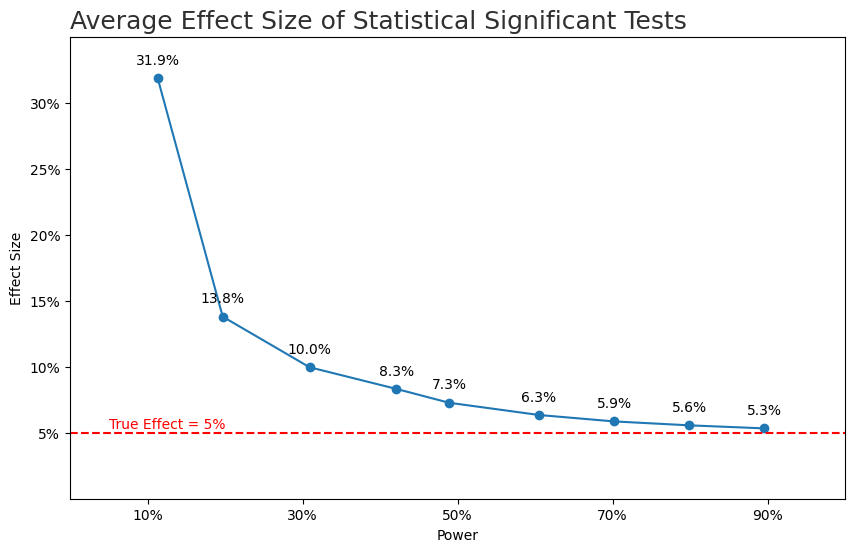

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot average estimated effect sizes per power level
plt.plot(df_grouped['power'], df_grouped['effect'], marker='o')

# Add horizontal line for the real effect size
plt.axhline(y=0.05, color='red', linestyle='--')
plt.text(0.2, 0.051, 'True Effect = 5%', color='red', fontsize=10, va='bottom', ha='right')

# Format y-axis as percentage points
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# Set y-axis limits
plt.ylim(0.0, 0.35)
plt.yticks(ticks=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

# Set x-axis limits
plt.xlim(0.0, 1.0)
# Set x-axis ticks to go from 0.1 to 0.9 in 0.2 steps
plt.xticks(ticks=[0.1, 0.3, 0.5, 0.7, 0.9])

# Add labels and title
plt.xlabel('Power')
plt.ylabel('Effect Size')
plt.title(label='Average Effect Size of Statistical Significant Tests',
          fontsize=18,
          color='#303030',
          loc='left')

for x,y in zip(df_grouped['power'],df_grouped['effect']):

    label = "{:,.1%}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


# Show the plot
plt.grid(False)
plt.show()


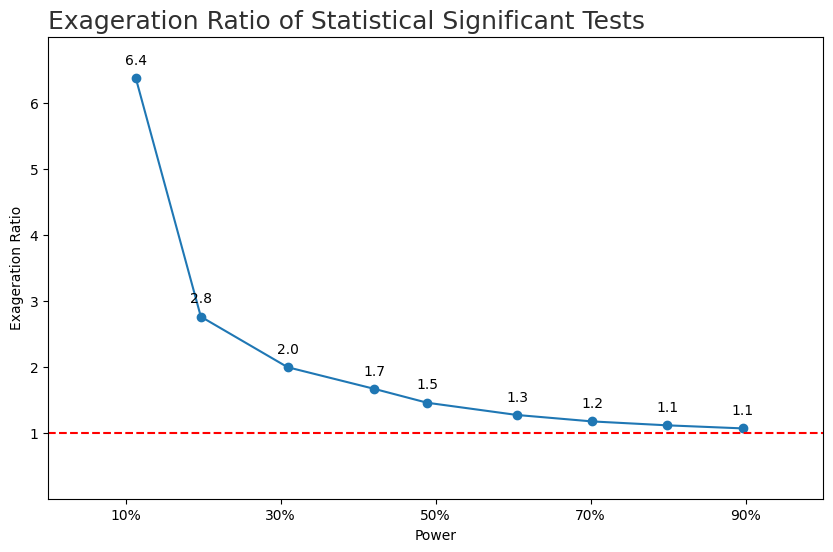

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot exageration ratio per power level
plt.plot(df_grouped['power'], df_grouped['exageration_ratio'], marker='o')

# Add horizontal line for the real effect size
plt.axhline(y=1, color='red', linestyle='--')

# Format y-axis
plt.ylim(0.0, 7.0)
plt.yticks(ticks=[1, 2, 3, 4, 5, 6])

# Format x-axis
plt.xlim(0.0, 1.0)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.xticks(ticks=[0.1, 0.3, 0.5, 0.7, 0.9])

# Add labels and title
plt.xlabel('Power')
plt.ylabel('Exageration Ratio')
plt.title(label='Exageration Ratio of Statistical Significant Tests',
          fontsize=18,
          color='#303030',
          loc='left')

for x,y in zip(df_grouped['power'],df_grouped['exageration_ratio']):

    label = "{:.1f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


# Show the plot
plt.grid(False)
plt.show()


From the above graphs we can see that the experiments with 30% power or less ended up with the average effect sizes (ATE) being overestimated by over a factor of 2. For a test with around 10% power the exageration rate was over 6 times the real effect.

# References


https://journals.sagepub.com/doi/10.1177/1745691614551642